In [205]:
import numpy as np
import pandas as pd
import EDHEC_risk_kit as erk
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
def discount(t,r):
    return(1+r)**(-t)

In [9]:
discount(10,.03)

0.7440939148967249

In [10]:
0.7440939148967249*(1+.03)**10

1.0

In [11]:
def pv(l,r):
    dates = l.index
    discounts=discount(dates,r)
    return (discounts * l).sum()

In [12]:
liabilities = pd.Series(data=[1,1.5,2,2.5],index = [3,3.5,4,4.5])

In [13]:
liabilities.sum()

7.0

In [14]:
pv(liabilities,0.03)

6.233320315080045

In [15]:
def funding_ratio(assets,liaibilties,r):
    return assets/pv(liabilities,r)

In [16]:
funding_ratio(5,liabilities,0.03) # deficit funding condition

0.8021407126958777

In [17]:
funding_ratio(5,liabilities,0.02) # when interest rate goes down, funding ration get worse

0.7720304366941648

In [18]:
funding_ratio(5,liabilities,0.07)

0.9311676560544035

In [19]:
import ipywidgets as widgets
from IPython.display import display

In [20]:
def show_funding_ratio(assets,r):
    fr = funding_ratio(assets,liabilities,r)
    print(f'{fr*100:.2f}')
    
controls = widgets.interactive(show_funding_ratio,
                              assets = widgets.IntSlider(min=1,max=10,step=1,value=5),
                              r = (0,.2,0.01))
display(controls)

interactive(children=(IntSlider(value=5, description='assets', max=10, min=1), FloatSlider(value=0.1, descript…

# Short Rate vs Annualized Rate

In [21]:
def inst_to_ann(r):
    return np.expm1(r)
def ann_to_inst(r):
    return log1p(r)

In [22]:
def cir(n_years=10,n_scenarios=1,a=0.05,b=0.03,sigma=.05,steps_per_year=12,r_0=None):
    if r_0 is None: r_0 = b
    r_0=inst_to_ann(r_0)
    dt=1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1
    shock = np.random.normal(0,scale = np.sqrt(dt),size=(num_steps,n_scenarios))
    rates = np.empty_like(shock)
    rates[0]=r_0
    for step in range(1,num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt+sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs( r_t+d_r_t)
        
    return pd.DataFrame(data = inst_to_ann(rates),index = range(num_steps))        

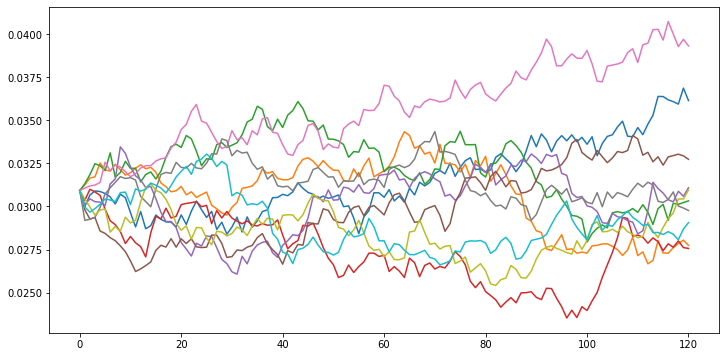

In [23]:
cir(n_scenarios=10,sigma=0.01).plot(legend=False,figsize=(12,6));

In [24]:
import ipywidgets as widgets
from IPython.display import display

In [25]:
def show_cir(n_years=10,n_scenarios=1,a=0.05,b=0.03,sigma=.05,steps_per_year=12,r_0=.03):
    ax = cir(n_years,n_scenarios,a,b,sigma,steps_per_year,r_0).plot(legend=False,figsize=(12,6))
    
control = widgets.interactive(show_cir,n_scenarios = (1,100),a=(0,1,0.1),b=(0,1,.05),r_0=(0,0.5,0.01),sigma=(0,0.5,.01))
display(control)

interactive(children=(IntSlider(value=10, description='n_years', max=30, min=-10), IntSlider(value=1, descript…

In [26]:
import math
def cir(n_years=10,n_scenarios=1,a=0.05,b=0.03,sigma=.05,steps_per_year=12,r_0=None):
    if r_0 is None: r_0 = b
    r_0=inst_to_ann(r_0)
    dt=1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1
    
    shock = np.random.normal(0,scale = np.sqrt(dt),size=(num_steps,n_scenarios))
    rates = np.empty_like(shock)
    rates[0]=r_0
    
    # price generalization
    h=math.sqrt(a**2+2*sigma**2)
    prices = np.empty_like(shock)
    
    def price(ttm,r):
        _A=((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h+(h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0]=price(n_years,r_0)
    
    for step in range(1,num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt+sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs( r_t+d_r_t)
        prices[step]=price(n_years-step*dt,rates[step])
    rates = pd.DataFrame(data = inst_to_ann(rates),index = range(num_steps)) 
    prices = pd.DataFrame(data=prices,index = range(num_steps))
    return rates, prices

In [27]:
# zero-bond price display

def show_cir_prices(n_scenarios=5,a=0.05,b=0.03,sigma=.05,r_0=.03):
    cir(n_scenarios=n_scenarios,a=a,b=b,sigma=sigma,r_0=r_0)[1].plot(legend=False,figsize=(12,6))

        
control = widgets.interactive(show_cir_prices,n_scenarios = (1,100),a=(0,1,0.1),b=(0,1,.01),r_0=(0,0.5,0.01),sigma=(0,0.5,.01))
display(control)

interactive(children=(IntSlider(value=5, description='n_scenarios', min=1), FloatSlider(value=0.05, descriptio…

In [28]:
import EDHEC_risk_kit as erk
a_0 = .75
rates,bond_prices = cir(n_years=10,r_0 =.03, b=.03, n_scenarios=15)
liabilities = bond_prices
zcbond_10=pd.Series(data=[1],index=[10])
zc_0 = erk.pv(zcbond_10,r=.03)
n_bonds = a_0/zc_0
av_zc_bonds= n_bonds*bond_prices
av_cash = a_0 *(1+rates/12).cumprod()

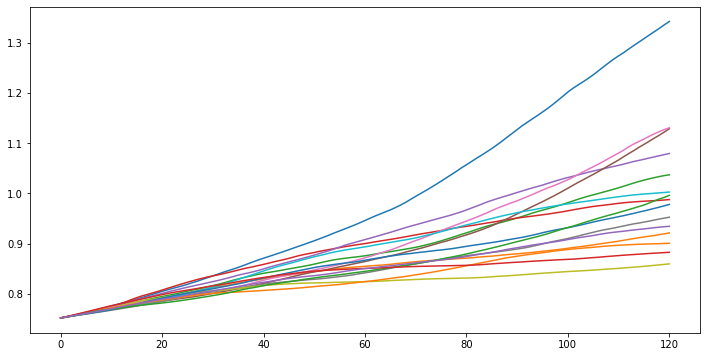

In [29]:
av_cash.plot(legend=False,figsize=(12,6));

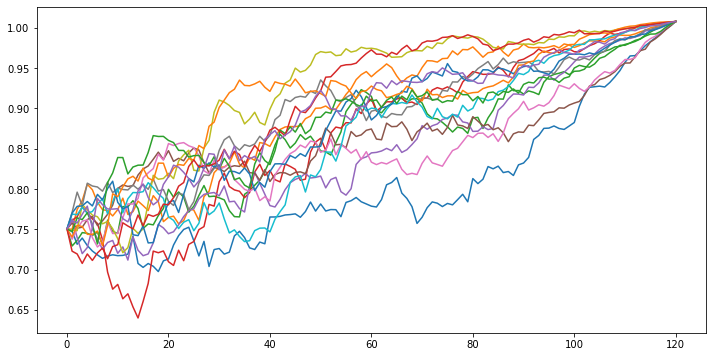

In [30]:
av_zc_bonds.plot(legend=False,figsize=(12,6));

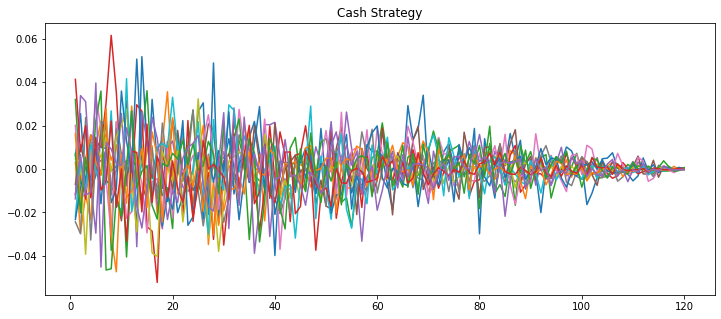

In [31]:
(av_cash/liabilities).pct_change().plot(title="Cash Strategy",legend=False,figsize=(12,5));# the funding ratio of cash-hedge strategy

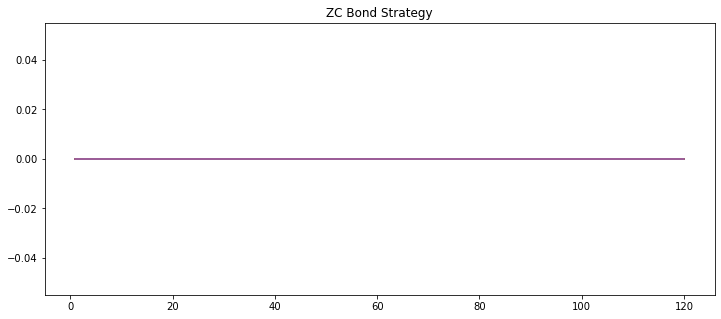

In [32]:
(av_zc_bonds/liabilities).pct_change().plot(title="ZC Bond Strategy",legend=False,figsize=(12,5)); # funding ratio of zero_coupon bond

In [33]:
a_0=.9
rates,bond_prices = cir(r_0 =.03, b=.03, n_scenarios=10000)
liabilities = bond_prices
zc_0 = erk.pv(zcbond_10,r=.03)
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds*bond_prices
av_cash = a_0 *(1+rates/12).cumprod()

tfr_cash =av_cash.iloc[-1]/liabilities.iloc[-1]

tfr_zc_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]


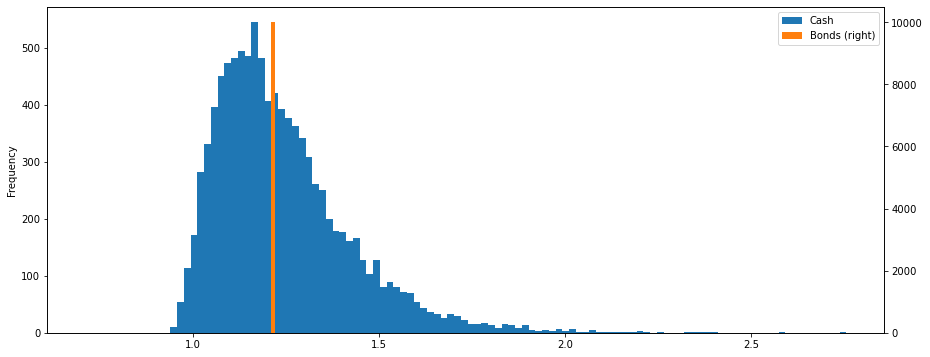

In [34]:
ax = tfr_cash.plot.hist(label="Cash",figsize=(15,6),bins = 100,legend=True)
tfr_zc_bonds.plot.hist(ax=ax,label="Bonds",bins=100,legend=True,secondary_y=True);

# GHP with Duration Matching

In [35]:
def bond_cash_flow(maturity,principal=1000,coupon_rate=.03,coupons_per_year=12):
    n_coupons = round(maturity*coupons_per_year)
    coupon_amt = principal*coupon_rate/coupons_per_year
    coupon_times = np.arange(1,n_coupons+1)
    cash_flows=pd.Series(data=coupon_amt,index=coupon_times)
    cash_flows.iloc[-1] += principal
    return cash_flows

In [36]:
cf = bond_cash_flow(3,1000,.06,2)
cf

1      30.0
2      30.0
3      30.0
4      30.0
5      30.0
6    1030.0
dtype: float64

In [308]:
import numpy as np
import pandas as pd
import EDHEC_risk_kit as erk
%load_ext autoreload
%autoreload 2

erk.bond_cash_flow(3,1000,.06,2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


1      30.0
2      30.0
3      30.0
4      30.0
5      30.0
6    1030.0
dtype: float64

In [309]:
discounts = erk.discount(cf.index,.06/2)
dcf = discounts*cf

In [310]:
weights = dcf/ dcf.sum()
weights

,0,1,2,3,4,5,6
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
(cf.index*weights).sum() # 麦考利久期

5.579707187194534

In [44]:
erk.macaulay_duration(cf,.06/2)  # 麦考利久期

5.579707187194534

In [285]:
cf1.index

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
           dtype='int64')

In [336]:
def macaulay_duration(flows,discount_rate):
    discount_flows = discount(flows.index,discount_rate)*flows
    weights = discount_flows/discount_flows.sum()
    #macaulay_duration = weights*flows.index
    macaulay_duration = np.average(flows.index, weights=weights)
    return macaulay_duration

cf1 = bond_cash_flow(15,1000,coupon_rate=0.05,coupons_per_year=2)
macaulay_duration(cf1,.05/2)/2

10.72677495379012

In [330]:
cf1 = bond_cash_flow(3,1000,coupon_rate=.05,coupons_per_year=1)
cf2 = bond_cash_flow(5,200000,coupon_rate=0,coupons_per_year=1)
cf3 = bond_cash_flow(10,300000,coupon_rate=0,coupons_per_year=1)
cf = pd.concat([cf1,cf2,cf3],axis=1)
cf = cf.fillna(0.0)

In [337]:
q = cf[0]+cf[1]+cf[2]
d_t=macaulay_duration(q,.05)
d_l = 10.73
d_s = 4.37
(d_l-d_t)/(d_l-d_s)

0.6256418470527279

In [341]:
l = 10
s = 4.37
t = macaulay_duration(q,.05)
(l-t)/(l-s)

0.5771016247345202

# Duration Matching

In [77]:
liabilities = pd.Series(data=[100000,100000],index = [10,12])
erk.macaulay_duration(liabilities,.04)

10.960799385088393

In [47]:
md_10 = erk.macaulay_duration(erk.bond_cash_flow(10,1000,.05,1),.04)
md_20 = erk.macaulay_duration(erk.bond_cash_flow(20,1000,.05,1),.04)

In [48]:
md_10,md_20

(8.190898824083233, 13.544718122145921)

In [ ]:
erk.match_durations()

In [66]:
liabilities = pd.Series(data=[100000,100000],index = [10,12])
erk.macaulay_duration(liabilities,0.04)

10.960799385088393

In [105]:
short_bond = erk.bond_cash_flow(10,1000,.05,1)
long_bond = erk.bond_cash_flow(20,1000,.05,1)
w_s = erk.match_durations(liabilities,short_bond,long_bond,0.04)

In [106]:
w_s

0.48263092069478974

In [121]:
p_short = erk.bond_price(10,1000,.05,1,.04)
p_long = erk.bond_price(20,1000,.05,1,.04)
a_0 = 130000
p_flows = pd.concat([a_0*w_s*short_bond/p_short, a_0*(1-w_s)*long_bond/p_long])# total cash flow
erk.macaulay_duration(p_flows,0.04)

10.960799385088393

In [139]:
liabilities = pd.Series(data=[100000,100000],index = [10,12])

cfr = erk.funding_ratio(p_flows, liabilities, 0.04) 
cfr

0.9998760012192478

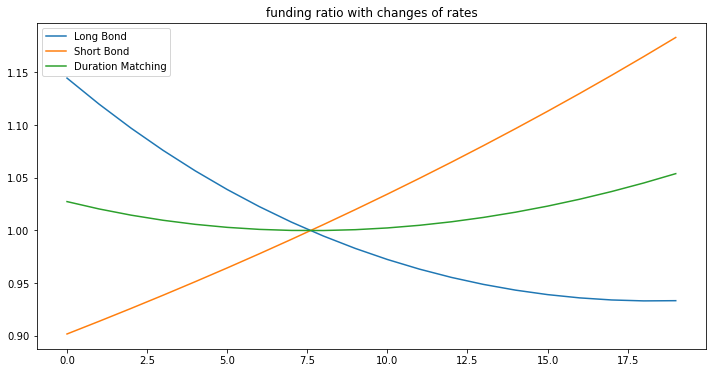

In [148]:
rates =np.linspace(0,.1,20)
lb=a_0*long_bond/p_long
sb=a_0*short_bond/p_short
fr_change = pd.DataFrame({"Long Bond":[erk.funding_ratio(lb,liabilities,r) for r in rates],
                          "Short Bond":[erk.funding_ratio(sb,liabilities,r) for r in rates],
                         "Duration Matching":[erk.funding_ratio(p_flows,liabilities,r) for r in rates]
                         })

fr_change.plot(title="funding ratio with changes of rates",figsize=(12,6));


In [146]:
fr_change

,Long Bond,Short Bond,Duration Matching
0,1.144464,0.901852,1.027372
1,1.119809,0.913844,1.020404
2,1.096992,0.926095,1.014512
3,1.075935,0.938613,1.009659
4,1.056570,0.951405,1.005814
5,1.038829,0.964481,1.002946
6,1.022651,0.977851,1.001029
7,1.007979,0.991523,1.000037
8,0.994759,1.005508,0.999947
9,0.982943,1.019815,1.000739


In [192]:
a_0*(1-w_s)*long_bond/p_long

1      2960.550536
2      2960.550536
3      2960.550536
4      2960.550536
5      2960.550536
6      2960.550536
7      2960.550536
8      2960.550536
9      2960.550536
10     2960.550536
11     2960.550536
12     2960.550536
13     2960.550536
14     2960.550536
15     2960.550536
16     2960.550536
17     2960.550536
18     2960.550536
19     2960.550536
20    62171.561257
dtype: float64

In [231]:
erk.funding_ratio(p_flows, liabilities, 0.04) 

0    0.999876
dtype: float64

In [149]:
erk.bond_price(5,100,.05,12,.03)

0    109.275393
dtype: float64

In [150]:
rates,zc_prices = erk.cir(10,500,b=.03,r_0=.03)

In [154]:
erk.bond_price(5,100,.05,12,rates.iloc[0][[1,2,3]]) # .iloc[]后面截取行数，若要截取列数，则双list [[]] !!!!!!!

1    108.827161
2    108.827161
3    108.827161
dtype: float64

In [155]:
erk.bond_price(5,100,.05,12,rates.iloc[1][[1,2,3]])

1    108.705186
2    107.467434
3    108.958990
dtype: float64

In [162]:
zc_prices

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.744489,0.744489,0.744489,0.744489,0.744489,0.744489,0.744489,0.744489,0.744489,0.744489,...,0.744489,0.744489,0.744489,0.744489,0.744489,0.744489,0.744489,0.744489,0.744489,0.744489
1,0.741979,0.744853,0.730914,0.747726,0.741421,0.750056,0.749416,0.730680,0.721802,0.734849,...,0.748566,0.772270,0.759529,0.726809,0.746611,0.733654,0.728939,0.730612,0.741767,0.741315
2,0.755396,0.739050,0.765328,0.777139,0.758502,0.771316,0.765084,0.738296,0.732774,0.724836,...,0.751892,0.765445,0.788443,0.761373,0.755564,0.704937,0.729574,0.728959,0.764237,0.735742
3,0.753468,0.721755,0.755542,0.767548,0.771758,0.785378,0.780993,0.750851,0.737013,0.703564,...,0.757523,0.737349,0.798076,0.729701,0.765853,0.713043,0.736823,0.721950,0.807044,0.752269
4,0.761091,0.732848,0.751247,0.754416,0.761767,0.767341,0.759402,0.744810,0.753836,0.709098,...,0.746321,0.719739,0.780082,0.771583,0.755118,0.666947,0.750200,0.704125,0.825290,0.770717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,0.998028,0.987512,0.989951,0.994678,0.984684,0.998004,0.990009,0.992726,0.984447,0.982177,...,0.996750,0.985077,0.999510,0.985821,0.999379,0.990197,0.979864,0.994207,0.980782,0.990153
117,0.998226,0.991049,0.993398,0.995777,0.988300,0.998370,0.992424,0.995611,0.988164,0.986422,...,0.997785,0.989070,0.999461,0.989555,0.999520,0.991977,0.984707,0.995771,0.985247,0.992983
118,0.998838,0.994144,0.995430,0.996574,0.992586,0.998814,0.994359,0.997477,0.992742,0.991237,...,0.998328,0.992151,0.999596,0.992837,0.999883,0.994450,0.989295,0.997440,0.989788,0.995158
119,0.999554,0.997433,0.997704,0.998522,0.995961,0.999415,0.996979,0.998842,0.996412,0.995716,...,0.999385,0.995545,0.999833,0.996396,0.999970,0.997271,0.994568,0.998745,0.994722,0.997631


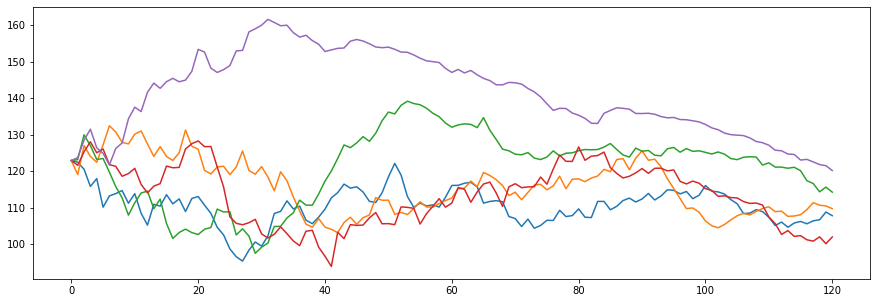

In [198]:
import EDHEC_risk_kit as erk
erk.bond_price(15,100,.05,12,rates[[1,2,3,4,5]]).plot(legend=False,figsize=(15,5));

In [199]:
prices = erk.bond_price(15,100,.05,12,rates[[1,2,3,4,5]])
prices

,1,2,3,4,5
0,122.873,122.873,122.873,122.873,122.873
1,122.433,119.026,123.141,121.59,123.716
2,120.484,126.974,129.94,125.273,128.474
3,115.784,124.002,126.983,128.037,131.471
4,117.933,122.409,123.188,125.003,126.387
...,...,...,...,...,...
116,105.542,109.448,117.36,101.158,123.201
117,106.363,111.335,116.57,100.78,122.505
118,106.646,110.646,114.311,101.962,121.785
119,108.764,110.43,115.595,100.085,121.469


In [200]:
br = prices.pct_change().dropna()
erk.an_ret(br,12)

1   -0.013042
2   -0.011283
3   -0.007280
4   -0.018518
5   -0.002250
dtype: float64

In [204]:
import EDHEC_risk_kit as erk
p = erk.bond_price(10,100,.05,12,rates[[1,2,3,4]])

btr = erk.bond_total_return(p,100,.05,12)
erk = erk.an_ret(btr,12)

erk

1    0.033291
2    0.031983
3    0.031490
4    0.032643
dtype: float64

In [209]:
price_10 = erk.bond_price(10,100,.05,12,rates)
price_10[[1,2,3]].tail()

,1,2,3
116,100.381,100.637,101.129
117,100.332,100.577,100.823
118,100.234,100.368,100.486
119,100.155,100.183,100.267
120,100.417,100.417,100.417


In [211]:
price_30 = erk.bond_price(30,100,.05,12,rates)
price_30[[1,2,3]].tail()

,1,2,3
116,116.216,129.042,158.939
117,119.052,136.172,156.53
118,120.232,134.142,148.135
119,127.806,133.831,154.157
120,124.622,131.581,149.223


In [212]:
rets_30 = erk.bond_total_return(price_30,100,.05,12)
rets_10 = erk.bond_total_return(price_10,100,.05,12)
rets_bonds = 0.4*rets_30+0.6*rets_10

In [220]:
mean_rets_bonds = rets_bonds.mean(axis="columns")
erk.summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualized ret,Annualized vol,Annualized sharp ratio,Skewness,Kortosis,Historical VaR(5%),Cornish_Fisher VaR(5%),Max Drawdown
0,0.036816,0.003789,1.798994,-0.039136,4.776223,0.000475,-0.001253,-0.000686


In [221]:
price_eq = erk.gbm(n_years= 10,n_scenarios = 500,mu = .07,sigma=.15)
price_eq.shape

(121, 500)

In [222]:
rets_eq = price_eq.pct_change().dropna()
rets_eq.shape

(120, 500)

In [230]:
rets = .7*rets_eq+.3*rets_bonds
rets_mean = rets.mean(axis="columns")
erk.summary_stats(pd.DataFrame(rets_mean))

,Annualized ret,Annualized vol,Annualized sharp ratio,Skewness,Kortosis,Historical VaR(5%),Cornish_Fisher VaR(5%),Max Drawdown
0,0.06093,0.004671,6.622369,-0.282865,3.104257,0.001928,-0.00263,0.0


# Risk budget strategies between PSP and GHP

In [232]:
def bt_mix(r1,r2,allocator,**keywargs):
    if not r1.shape==r2.shape:
        raise ValueError("r1 and r2 should be in the same shape")
    weights(r1,r2,**keywargs)
    if not weights.shape == r1.shape:
        raise ValueError("Allocator's weights don't match r1")
    r_mix = r1*weights+(1-weights)*r2
    return r_mix

In [234]:
def fixedmix_allocator(r1,r2,w1,**kwargs):
    return pd.DataFrame(data = w1, index = r1.index, columns = r1.columns)

In [237]:
rates,zc_prices = erk.cir(10,500,b=.03,r_0=.03)
price_10 = erk.bond_price(10,100,.05,12,rates)
price_30 = erk.bond_price(30,100,.05,12,rates)
rets_30 = erk.bond_total_return(price_30,100,.05,12)
rets_10 = erk.bond_total_return(price_10,100,.05,12)
rets_bond = erk.bt_mix(rets_10,rets_30,allocator=erk.fixedmix_allocator,w1=0.6)
mean_rets_bond = rets_bond.mean(axis="columns")
erk.summary_stats(pd.DataFrame(mean_rets_bond)) 

,Annualized ret,Annualized vol,Annualized sharp ratio,Skewness,Kortosis,Historical VaR(5%),Cornish_Fisher VaR(5%),Max Drawdown
0,0.037345,0.004031,1.821948,-0.072923,3.637845,0.000488,-0.001146,-0.000344


In [261]:
price_eq =  erk.gbm(n_years= 10,n_scenarios = 500,mu = .07,sigma=.15)
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()
rets_7030b = erk.bt_mix(rets_eq,rets_zc,allocator=erk.fixedmix_allocator,w1=0.7)
rets_7030b_mean = rets_7030b.mean(axis=1)
erk.summary_stats(pd.DataFrame(rets_7030b_mean)) 

,Annualized ret,Annualized vol,Annualized sharp ratio,Skewness,Kortosis,Historical VaR(5%),Cornish_Fisher VaR(5%),Max Drawdown
0,0.058384,0.004884,5.811384,-0.07854,2.744102,0.001856,-0.002393,0.0


In [239]:
summaries = erk.summary_stats(pd.DataFrame(rets_7030b)) 

In [242]:
summaries.shape

(500, 8)

In [241]:
summaries.mean()

Annualized ret            0.051424
Annualized vol            0.105333
Annualized sharp ratio    0.204049
Skewness                 -0.015003
Kortosis                  2.912805
Historical VaR(5%)       -0.057396
Cornish_Fisher VaR(5%)    0.045351
Max Drawdown             -0.207438
dtype: float64

In [243]:
def terminal_values(rets):
    return (rets+1).prod()

In [267]:
pd.concat([erk.terminal_stats(rets_bonds,name="FI"),
          erk.terminal_stats(rets_eq,name="EQ"),
          erk.terminal_stats(rets_7030b,name="70/30")],axis=1)

,FI,EQ,70/30
mean,1.395183,1.961027,1.757048
std,0.113343,0.923604,0.571206
p_breach,NaN,0.038000,0.008000
e_short,NaN,0.133252,0.126816
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


In [255]:
def terminal_stats(rets,floor=.8,cap = np.inf,name="Stats"):
    terminal_wealth = (rets+1).prod()
    breach = terminal_wealth<floor
    reach = terminal_wealth>=cap
    p_breach = breach.mean() if breach.sum()>0 else np.nan
    p_reach = breach.mean() if breach.sum()>0 else np.nan
    e_short = (floor-terminal_wealth[breach]).mean() if breach.sum()>0 else np.nan
    e_surplus = (cap-terminal_wealth[reach]).mean() if reach.sum()>0 else np.nan
    sum_stats = pd.DataFrame.from_dict({
                   "mean" : terminal_wealth.mean(),
                   "std":terminal_wealth.std(),
                   "p_breach":p_breach,
                   "e_short":e_short,
                   "p_reach":p_reach,
                   "e_surplus":e_surplus
                   },orient="index",columns=[name])
    return sum_stats
                   

In [262]:
pd.concat([erk.terminal_stats(rets_bonds,name="FI"),
          erk.terminal_stats(rets_eq,name="EQ"),
          erk.terminal_stats(rets_7030b,name="70/30")],axis=1)

,FI,EQ,70/30
mean,1.395183,1.961027,1.757048
std,0.113343,0.923604,0.571206
p_breach,NaN,0.038000,0.008000
e_short,NaN,0.133252,0.126816
p_reach,NaN,0.038000,0.008000
e_surplus,NaN,NaN,NaN


In [263]:
def glidepath_allocator(r1,r2,start_glide=1,end_glide=0):
    n_points = r1.shape[0]
    n_col = r1.shape[1]
    path = pd.Series(data=np.linspace(start_glide,end_glide,num=n_points))
    paths = pd.concat([path]*n_col,axis=1)
    paths.index = r1.index
    paths.columns = r1.columns
    return paths

In [266]:
rets_g8020= erk.bt_mix(rets_eq,rets_bonds,allocator = erk.glidepath_allocator,start_glide=.8,end_glide=.2)
pd.concat([erk.terminal_stats(rets_bonds,name="FI"),
          erk.terminal_stats(rets_eq,name="EQ"),
          erk.terminal_stats(rets_7030b,name="70/30"),
          erk.terminal_stats(rets_g8020,name="glide 80/20")
         ],axis=1)

,FI,EQ,70/30,glide 80/20
mean,1.395183,1.961027,1.757048,1.661273
std,0.113343,0.923604,0.571206,0.427202
p_breach,NaN,0.038000,0.008000,0.006000
e_short,NaN,0.133252,0.126816,0.018406
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


In [273]:
p1 = erk.bond_price(15,1000,.05,2,.05)
p1

0    1000.0
dtype: float64

In [274]:
p2 =erk.bond_price(5,1000,.06,4,.05)
p2

0    1043.99829
dtype: float64

In [275]:
p3=erk.bond_price(10,1000,0,1,.05)
p3

0    613.913254
dtype: float64

In [276]:
cf1 = erk.bond_cash_flow(maturity = 15,principal=1000,coupon_rate=.05,coupons_per_year=2)
cf2 = erk.bond_cash_flow(maturity = 5,principal=1000,coupon_rate=.06,coupons_per_year=4)
cf3 = erk.bond_cash_flow(maturity = 10,principal=1000,coupon_rate=0,coupons_per_year=1)

In [1]:
def x(n_years = 10, k=0.2, sigma=0.05, steps_per_year=12,r_0=.03):
    """
    Evolution of Geometric Brownian Motion trajectories, such as for Stock Prices through Monte Carlo
    :param n_years:  The number of years to generate data for
    :param n_paths: The number of scenarios/trajectories
    :param mu: Annualized Drift, e.g. Market Return
    :param sigma: Annualized Volatility
    :param steps_per_year: granularity of the simulation
    :param s_0: initial value
    :return: a numpy array of n_paths columns and n_years*steps_per_year rows
    """
    # Derive per-step Model Parameters from User Specifications
    dt = 1/steps_per_year
    n_steps = int(n_years*steps_per_year) + 1
    # the standard way ...
    # rets_plus_1 = np.random.normal(loc=mu*dt+1, scale=sigma*np.sqrt(dt), size=(n_steps, n_scenarios))
    # without discretization error ...
    rets_plus_1 = np.random.normal(loc=(1+mu)**dt, scale=(sigma*np.sqrt(dt)), size=(n_steps, n_scenarios))
    rets_plus_1[0] = 1
    ret_val = s_0*pd.DataFrame(rets_plus_1).cumprod() if prices else rets_plus_1-1
    return ret_val

In [43]:
import numpy as np
import pandas as pd
r=pd.Series(data=np.nan,index = range(12))
def x(n_years = 10, k=0.2, sigma=0.05, steps_per_year=12,r_0=.03,count=1):
    dt = 1/steps_per_year
    drt = k*(sigma - r_0)*dt + (sigma*np.sqrt(dt)*np.random.normal(0,1))
    r.append(drt+r_0)
    r_0 = r
    count +=1
    if count == 12:
        return r

In [45]:
x()

TypeError: cannot concatenate object of type '<class 'numpy.float64'>'; only Series and DataFrame objs are valid